# Wildlife Vision – Experiment Log Visualization (JSONL)

이 노트북은 `log_experiment()`로 저장된 JSONL 로그를 불러와서, 하이퍼파라미터(C, scaler, class_weight 등)와 성능(log loss)을 빠르게 비교/시각화합니다.


In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from src.config.paths import *

assert LOG_PATH.exists(), f'log file not found: {LOG_PATH.resolve()}'
print('Using log:', LOG_PATH.resolve())


Using log: C:\Users\osca0\Github\WildlifeVision-Baseline\artifacts\experiments\experiments.jsonl


In [15]:
def load_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open('r', encoding='utf-8') as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError as e:
                raise ValueError(f'Invalid JSON at line {line_no}: {e}')
    return pd.json_normalize(rows)

df = load_jsonl(LOG_PATH)
df.head(3)

,run_id,timestamp,tag,feature_name,model_name,env.python,env.sklearn,cv.type,cv.n_splits,params.logreg.C,...,data_signature.class_counts.monkey_prosimian,data_signature.class_counts.rodent,cv_checks.site_single_fold,cv_checks.no_site_overlap,cv_checks.random_state,fold_site_counts.0,fold_site_counts.1,fold_site_counts.2,fold_site_counts.3,fold_site_counts.4
0,865f8a108c,2026-02-14T05:48:02.785432+00:00,logreg_hog_grid_v1,hog,logreg,3.12.10,1.8.0,GroupKFold(site),5,1.0,...,2492,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,228cfd9359,2026-02-14T05:56:04.329051+00:00,logreg_hog_grid_v1,hog,logreg,3.12.10,1.8.0,GroupKFold(site),5,0.1,...,2492,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4a41e76f7f,2026-02-14T05:56:55.583717+00:00,logreg_hog_grid_v1,hog,logreg,3.12.10,1.8.0,GroupKFold(site),5,1.0,...,2492,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 컬럼 정리
- `params.logreg.C`, `params.logreg.use_scaler`, `params.logreg.class_weight` 등은 실험 비교의 핵심입니다.
- 로그 스키마 버전에 따라 일부 키가 없을 수 있어, 없는 경우 NaN으로 처리합니다.


In [16]:
# 주요 컬럼을 안전하게 꺼내기
def get_col(name: str):
    return df[name] if name in df.columns else np.nan

view = pd.DataFrame({
    'run_id': get_col('run_id'),
    'timestamp': get_col('timestamp'),
    'tag': get_col('tag'),
    'C': get_col('params.logreg.C').astype(float, errors='ignore'),
    'use_scaler': get_col('params.logreg.use_scaler'),
    'class_weight': get_col('params.logreg.class_weight'),
    'mean_log_loss': get_col('metrics.mean_log_loss').astype(float, errors='ignore'),
    'std_log_loss': get_col('metrics.std_log_loss').astype(float, errors='ignore'),
})

# 타입 정리
if 'use_scaler' in view.columns:
    view['use_scaler'] = view['use_scaler'].astype('boolean')
view['class_weight'] = view['class_weight'].fillna('None').astype(str)

view.sort_values(['tag','use_scaler','class_weight','C']).head(10)

,run_id,timestamp,tag,C,use_scaler,class_weight,mean_log_loss,std_log_loss
4,77ae706413,2026-02-14T06:04:26.266048+00:00,logreg_hog_grid_v1,0.1000,False,None,2.346503,0.168600
5,f6d7abdf61,2026-02-14T06:10:29.929334+00:00,logreg_hog_grid_v1,1.0000,False,None,3.697963,0.386807
6,f4a866a62f,2026-02-14T06:13:06.263814+00:00,logreg_hog_grid_v1,10.0000,False,None,7.410723,0.952548
1,228cfd9359,2026-02-14T05:56:04.329051+00:00,logreg_hog_grid_v1,0.1000,True,None,6.715954,0.659563
0,865f8a108c,2026-02-14T05:48:02.785432+00:00,logreg_hog_grid_v1,1.0000,True,None,11.774269,0.872163
2,4a41e76f7f,2026-02-14T05:56:55.583717+00:00,logreg_hog_grid_v1,1.0000,True,None,11.774269,0.872163
3,85ec3c49cc,2026-02-14T05:57:49.184697+00:00,logreg_hog_grid_v1,10.0000,True,None,19.907009,0.807016
20,672e2cc70c,2026-02-14T08:02:48.337613+00:00,logreg_hog_grid_v2,0.0005,False,None,1.937138,0.028772
21,2136b2271a,2026-02-14T08:07:22.642863+00:00,logreg_hog_grid_v2,0.0010,False,None,1.902755,0.038686
22,bc932fda7f,2026-02-14T08:08:19.928099+00:00,logreg_hog_grid_v2,0.0020,False,None,1.882167,0.053033


## 베스트 설정 확인
tag별로 mean_log_loss가 가장 낮은 run을 확인합니다.


In [17]:
best_by_tag = (
    view.dropna(subset=['mean_log_loss'])
        .sort_values(['tag','mean_log_loss'])
        .groupby('tag', as_index=False)
        .head(5)
)
best_by_tag

,run_id,timestamp,tag,C,use_scaler,class_weight,mean_log_loss,std_log_loss
4,77ae706413,2026-02-14T06:04:26.266048+00:00,logreg_hog_grid_v1,0.100,False,None,2.346503,0.168600
5,f6d7abdf61,2026-02-14T06:10:29.929334+00:00,logreg_hog_grid_v1,1.000,False,None,3.697963,0.386807
1,228cfd9359,2026-02-14T05:56:04.329051+00:00,logreg_hog_grid_v1,0.100,True,None,6.715954,0.659563
6,f4a866a62f,2026-02-14T06:13:06.263814+00:00,logreg_hog_grid_v1,10.000,False,None,7.410723,0.952548
0,865f8a108c,2026-02-14T05:48:02.785432+00:00,logreg_hog_grid_v1,1.000,True,None,11.774269,0.872163
28,7d251ed19c,2026-02-14T08:14:25.751473+00:00,logreg_hog_grid_v2,0.003,False,balanced,1.863950,0.095133
15,8658ec25de,2026-02-14T07:52:22.938770+00:00,logreg_hog_grid_v2,0.005,False,balanced,1.867760,0.104737
29,23a7342baa,2026-02-14T08:15:35.599149+00:00,logreg_hog_grid_v2,0.005,False,balanced,1.867760,0.104737
27,8fa9cbafa6,2026-02-14T08:13:30.415092+00:00,logreg_hog_grid_v2,0.002,False,balanced,1.869184,0.085049
23,f55f861230,2026-02-14T08:10:29.296938+00:00,logreg_hog_grid_v2,0.003,False,None,1.877086,0.061663


## 시각화 1: C에 따른 mean log loss
- y축이 낮을수록 좋습니다.
- `use_scaler` / `class_weight` 조합에 따라 곡선이 달라질 수 있습니다.


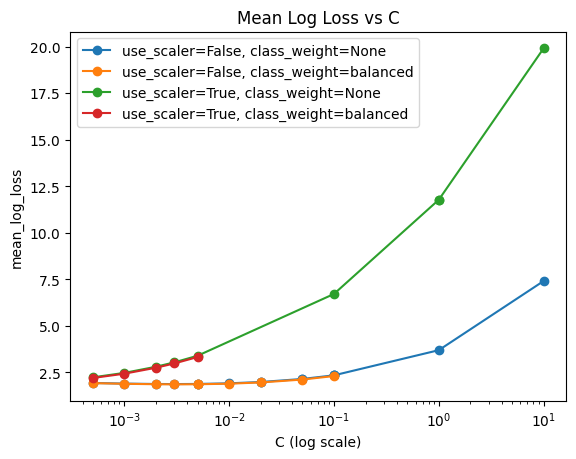

In [18]:
def plot_mean_log_loss(df_in: pd.DataFrame, tag: str | None = None):
    d = df_in.copy()
    if tag is not None:
        d = d[d['tag'] == tag]
    d = d.dropna(subset=['C','mean_log_loss'])

    # 그룹별 라인
    groups = d.groupby(['use_scaler','class_weight'], dropna=False)
    plt.figure()
    for (use_scaler, cw), g in groups:
        g = g.sort_values('C')
        label = f'use_scaler={use_scaler}, class_weight={cw}'
        plt.plot(g['C'], g['mean_log_loss'], marker='o', label=label)
    plt.xscale('log')
    plt.xlabel('C (log scale)')
    plt.ylabel('mean_log_loss')
    plt.title(f'Mean Log Loss vs C' + (f' | tag={tag}' if tag else ''))
    plt.legend()
    plt.show()

plot_mean_log_loss(view)

## 시각화 2: 에러바(std) 포함
- fold 간 변동이 큰 조합은 std가 커집니다.


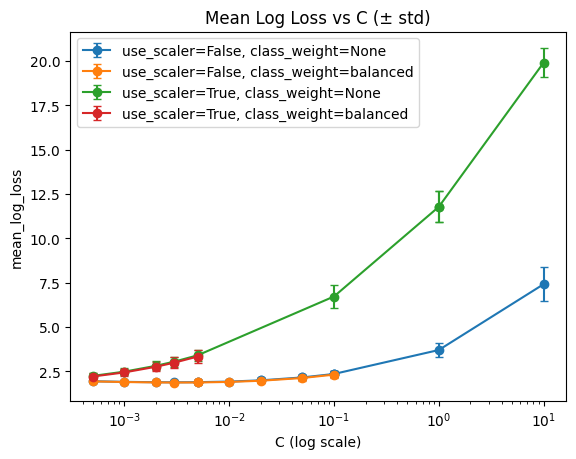

In [19]:
def plot_with_errorbars(df_in: pd.DataFrame, tag: str | None = None):
    d = df_in.copy()
    if tag is not None:
        d = d[d['tag'] == tag]
    d = d.dropna(subset=['C','mean_log_loss','std_log_loss'])
    groups = d.groupby(['use_scaler','class_weight'], dropna=False)

    plt.figure()
    for (use_scaler, cw), g in groups:
        g = g.sort_values('C')
        label = f'use_scaler={use_scaler}, class_weight={cw}'
        plt.errorbar(g['C'], g['mean_log_loss'], yerr=g['std_log_loss'], marker='o', capsize=3, label=label)
    plt.xscale('log')
    plt.xlabel('C (log scale)')
    plt.ylabel('mean_log_loss')
    plt.title(f'Mean Log Loss vs C (± std)' + (f' | tag={tag}' if tag else ''))
    plt.legend()
    plt.show()

plot_with_errorbars(view)

## (선택) 태그별로 자동 출력
실험 태그가 여러 개면, 태그별로 그래프를 분리해서 확인할 수 있습니다.


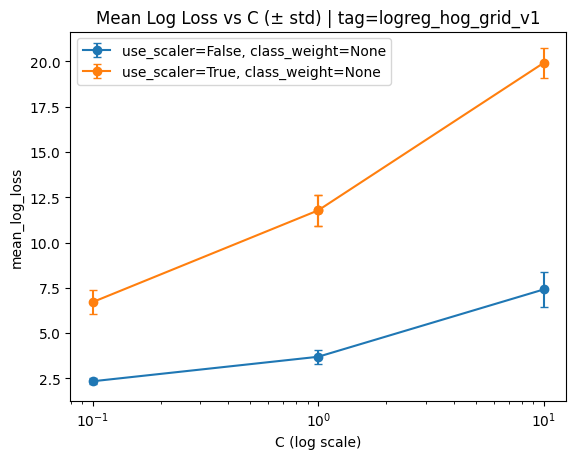

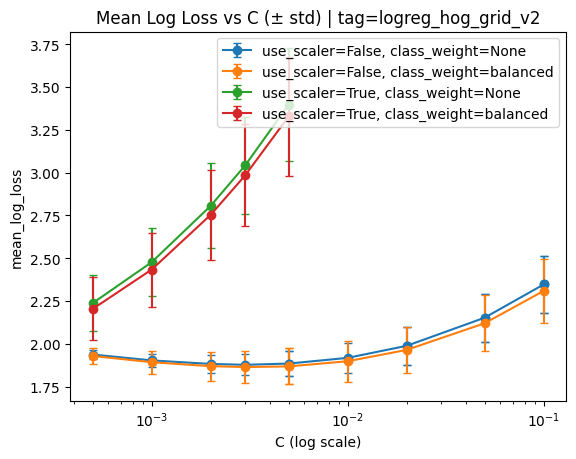

In [20]:
for t in sorted(view['tag'].dropna().unique()):
    plot_with_errorbars(view, tag=t)
